In [4]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

# IGNITE
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping

from collections import defaultdict, namedtuple, Counter
import shutil

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## eda & split dataset
1. labels分布， 0-7
    *  7    5523
    * 3    3416
    * 6    2558
    * 5    2281
    * 1    2066
    * 4    1956
    * 2    1780
    * 0    1468
2. train -> train validation set
    * train  80% val 20%
   
3. sets size
    * all - 21048
    * train - 18943
    * valid - 2105

annotations = pd.read_csv(annotation_file)

In [ ]:
# train val split 
from sklearn.model_selection import train_test_split
X = annotations['Image']
Y = annotations['Cloth_label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
train = pd.DataFrame([X_train, y_train]).T
valid = pd.DataFrame([X_test, y_test]).T

In [ ]:
train.sort_index()
valid.sort_index()
train.to_csv(os.path.join(data_path, 'train_list.csv'), index=0)
valid.to_csv(os.path.join(data_path, 'valid_list.csv'), index=0)

### Config

In [8]:
# data path 
data_path = '/data1/yangyy/ann2'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
sub_path = os.path.join(data_path, 'sub')
annotation_file = os.path.join(data_path, 'train.csv')
training_file  = os.path.join(data_path, 'train_list.csv')
valid_file = os.path.join(data_path, 'valid_list.csv')

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size = 64


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

### Model Training and Validation Code

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_loss)
            if phase =='train':
                train_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Initialize and reshape the networks

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier.in_features
#         model_ft.classifier = nn.Linear(num_ftrs, num_classes)
#         input_size = 224
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# data loading and preprocessing

In [9]:
# torch.utils.data.Dataset is an abstract class representing a dataset
class ClothDataset(Dataset):
    """Cloth dataset"""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to scv file with annotations
            root_dir (string): Directory with all the images.
            transforms (callable, optional)
        """
        self.cloth_labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.cloth_labels)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.cloth_labels.iloc[idx, 0])

        # convert to RGB seems to fix "Sizes of tensors must match except in dimension 0. Got 3 and 4 in dimension 1"
        image = Image.open(img_name).convert('RGB')
        label = self.cloth_labels.iloc[idx, 1]
        
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

## transforms
* Rescale: to scale the image
* RandomCrop: to crop from image randomly. This is data augmentation.
* ToTensor: to convert the numpy images to torch images (we need to swap axes).

In [34]:
# Data augmentation and normalization for training
# Just normalization for validation
input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

training_set = ClothDataset(training_file, train_path, transform=data_transforms['train'])
valid_set = ClothDataset(valid_file, train_path, transform=data_transforms['val'])

dataloaders_dict = {'train': DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=8), 
                        'val': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8)}


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

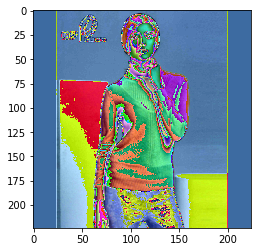

In [35]:
image, label = valid_set[5]
pilTrans = transforms.ToPILImage()
pilImg = pilTrans(image)
plt.imshow(pilImg)

## CREATE THE OPTIMIZER

In [8]:
model_ft = torch.load(os.path.join(data_path, 'models/res50-0107.pth'))

In [9]:
for param in model_ft.parameters():
    param.requires_grad = True

# Send the model to GPU
model_ft = model_ft.to(device)

In [11]:


# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model_ft.parameters()

# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# res50 0.001 for 9 epochs store and 0.0001 for 4 epochs
# dense161 0.01 fc for 10 epochs 0.001 for 5 epoch， 0.0001 for 

## RUN TRAINING AND VALIDATION STEP

In [12]:
# Number of epochs to train for
num_epochs = 5

In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/4
----------
train Loss: 0.7007 Acc: 0.7523
val Loss: 0.5165 Acc: 0.8280

Epoch 1/4
----------
train Loss: 0.5489 Acc: 0.8082
val Loss: 0.4433 Acc: 0.8480

Epoch 2/4
----------
train Loss: 0.4871 Acc: 0.8309
val Loss: 0.3982 Acc: 0.8570

Epoch 3/4
----------
train Loss: 0.4418 Acc: 0.8460
val Loss: 0.3864 Acc: 0.8656

Epoch 4/4
----------
train Loss: 0.4143 Acc: 0.8531
val Loss: 0.3863 Acc: 0.8741

Training complete in 9m 26s
Best val Acc: 0.874109


In [14]:
torch.save(model_ft, os.path.join(data_path, 'models/dense161full1e-3for5e.pth'))

# plot 

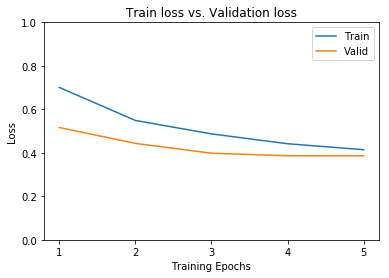

In [14]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
thist = train_hist
vhist = val_hist

# thist = [h.cpu().numpy() for h in train_hist]
# vhist = [h.cpu().numpy() for h in  val_hist]

plt.title("Train loss vs. Validation loss")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),thist,label="Train")
plt.plot(range(1,num_epochs+1),vhist,label="Valid")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

有时候我们需要对全局都进行finetune，只不过我们希望改换过的层和其他层的学习速率不一样，这时候我们可以把其他层和新层在optimizer中单独赋予不同的学习速率。

In [28]:
ignored_params = list(map(id, model_ft.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model_ft.parameters())

optimizer_all = torch.optim.SGD([
            {'params': base_params},
            {'params': model_ft.fc.parameters(), 'lr': 1e-2}
            ], lr=1e-3, momentum=0.9)

In [29]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_all, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/99
----------
train Loss: 0.8264 Acc: 0.7109
val Loss: 0.8423 Acc: 0.7173

Epoch 1/99
----------
train Loss: 0.8523 Acc: 0.6966
val Loss: 0.8411 Acc: 0.7021

Epoch 2/99
----------
train Loss: 0.8526 Acc: 0.6997
val Loss: 0.8158 Acc: 0.7207

Epoch 3/99
----------
train Loss: 0.8353 Acc: 0.7044
val Loss: 0.7310 Acc: 0.7468

Epoch 4/99
----------
train Loss: 0.8367 Acc: 0.7065
val Loss: 0.8013 Acc: 0.7235

Epoch 5/99
----------
train Loss: 0.8241 Acc: 0.7127
val Loss: 0.7911 Acc: 0.7297

Epoch 6/99
----------
train Loss: 0.8179 Acc: 0.7116
val Loss: 0.6975 Acc: 0.7625

Epoch 7/99
----------
train Loss: 0.8381 Acc: 0.7074
val Loss: 0.7128 Acc: 0.7615

Epoch 8/99
----------
train Loss: 0.8226 Acc: 0.7127
val Loss: 0.7743 Acc: 0.7492

Epoch 9/99
----------
train Loss: 0.8119 Acc: 0.7157
val Loss: 0.8251 Acc: 0.7202

Epoch 10/99
----------
train Loss: 0.8106 Acc: 0.7132
val Loss: 0.7972 Acc: 0.7169

Epoch 11/99
----------
train Loss: 0.8146 Acc: 0.7117
val Loss: 0.8714 Acc: 0.7002

Ep

train Loss: 0.7387 Acc: 0.7410
val Loss: 0.6310 Acc: 0.7791

Epoch 99/99
----------
train Loss: 0.7330 Acc: 0.7451
val Loss: 0.7310 Acc: 0.7487

Training complete in 66m 24s
Best val Acc: 0.780998


In [30]:
torch.save(model_ft, os.path.join(data_path, 'models/model1228furtuning.pth'))

# Inference


In [15]:
# torch.utils.data.Dataset is an abstract class representing a dataset
class ClothTestDataset(Dataset):
    """Cloth dataset"""
    def __init__(self, test_dir, transform=None):
        """
        Args:
            test_dir (string): Directory with all the test images.
            transforms (callable, optional)
        """
#         self.cloth_labels = pd.read_csv(csv_file)
#         self.root_dir = root_dir
        self.test_dir = test_dir
        self.cloth_names = os.listdir(test_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.cloth_names)
    
    def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir, self.cloth_labels.iloc[idx, 0])
        img_name = self.cloth_names[idx]

        # convert to RGB seems to fix "Sizes of tensors must match except in dimension 0. Got 3 and 4 in dimension 1"
        image = Image.open(os.path.join(self.test_dir, img_name)).convert('RGB')
        
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_name
    
input_size = 224
test_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_set = ClothTestDataset(test_path, transform=test_transform)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=8)


In [16]:
def test(model, dataloader, sub_name):
    name_list = []
    pred_list = []
    
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    
    for inputs, names in dataloader:
        inputs = inputs.to(device)
#         names = names.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        name_list.extend(names)
        pred_list.extend(list(preds))
    
    test_df = pd.DataFrame(columns=['Image', 'Cloth_label'])
    test_df['Image'] = name_list
    test_df['Cloth_label'] = pred_list
    test_df['Cloth_label'] = test_df['Cloth_label'].apply(lambda x: int(x))
    
    test_df.to_csv(os.path.join(sub_path, sub_name), index=False)

In [6]:
model = torch.load(os.path.join(data_path, 'models/res50-0107v2.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
test(model_ft, test_dataloader, 'sub.csv')